# Text-To-Image Search Pipeline with Multimodal Retriever

**Level**: Intermediate

**Time to complete**: 20 minutes

**Prerequisites**: This tutorial assumes basic knowledge of Haystack Retrievers and Pipelines. If you want to learn about them, have a look at our tutorials on [Build Your First QA System](https://github.com/deepset-ai/haystack-tutorials/blob/main/tutorials/01_Basic_QA_Pipeline.ipynb) and [Fine-Tuning a Model on Your Own Data](https://github.com/deepset-ai/haystack-tutorials/blob/main/tutorials/02_Finetune_a_model_on_your_data.ipynb).

Prepare the Colab environment (see links below).

**Nodes Used**: InMemoryDocumentStore, MultiModalRetriever

**Goal**: After completing this tutorial, you will have built a search system that retrieves images as answers to a text query.

**Description**: In this tutorial, you'll download a set of images that you'll then turn into embeddings using a transformers model, OpenAI CLIP. You'll then use the same model to embed the text query. Finally, you'll perform a nearest neighbor search to retrieve the images relevant to the text query.

Let's build a text-to-image search pipeline using a small animal dataset!

## Preparing the Colab Environment

- [Enable GPU Runtime in Colab](https://docs.haystack.deepset.ai/docs/enabling-gpu-acceleration#enabling-the-gpu-in-colab)
- [Set logging level to INFO](https://docs.haystack.deepset.ai/docs/log-level)

## Installing Haystack

In [24]:
%%bash

pip install --upgrade pip
pip install farm-haystack[colab]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Initializing the DocumentStore

A DocumentStore stores references to the images that Haystack will compare with your query. But before it can do that, you need to initialize it. In this tutorial, you'll use the InMemoryDocumentStore.

If you want to learn more, see [DocumentStore](https://docs.haystack.deepset.ai/docs/document_store).

In [13]:
from haystack.document_stores import InMemoryDocumentStore

# Here Here we initialize the DocumentStore to store 512 dim image embeddings
# obtained using OpenAI CLIP model
document_store = InMemoryDocumentStore(embedding_dim=512)

## Downloading Data

Download 18 sample images of different animals and store it. You can find them in data/tutorial19/spirit-animals/ as a set of .jpg files.

In [14]:
from haystack.utils import fetch_archive_from_http

doc_dir = "data/wikiarts"

fetch_archive_from_http(
    url="https://s3.eu-central-1.amazonaws.com/deepset.ai-farm-qa/datasets/documents/spirit-animals.zip",
    output_dir=doc_dir,
)

False

Add the images you just downloaded into Haystack Document objects and write them into the DocumentStore.

In [15]:
import os

from haystack import Document

images = [
    Document(content=f"./{doc_dir}/spirit-animals/{filename}", content_type="image")
    for filename in os.listdir(f"./{doc_dir}/spirit-animals/")
]

document_store.write_documents(images)

You have successfully stored your images in the DocumentStore.



## Initializing the Retriever

Retrievers sift through all the images and return only those that are relevant to the query. To run a search on images, you'll use the MultiModalRetriever with the [OpenAI CLIP model](https://github.com/openai/CLIP/blob/main/model-card.md). 

For more details on supported modalities, see [MultiModalRetriever](https://docs.haystack.deepset.ai/docs/retriever#multimodal-retrieval).

Before adding the Retriever to your pipeline, let's configure its parameters

In [16]:
from haystack.nodes.retriever.multimodal import MultiModalRetriever

retriever_text_to_image = MultiModalRetriever(
    document_store=document_store,
    query_embedding_model="sentence-transformers/clip-ViT-B-32",
    query_type="text",
    document_embedding_models={"image": "sentence-transformers/clip-ViT-B-32"},
)

# Now let's turn our images into embeddings and store them in the DocumentStore.
document_store.update_embeddings(retriever=retriever_text_to_image)

Updating Embedding:   0%|          | 0/18 [00:00<?, ? docs/s]

Create embeddings:   0%|          | 0/2 [00:00<?, ? Docs/s]

RuntimeError: ignored

 Your retriever is now ready for search!

## Creating the MultiModal Search Pipeline

We are populating a pipeline with a MultiModalRetriever node. This search pipeline queries the image database with text and returns the most relevant images.

In [6]:
from haystack import Pipeline

pipeline = Pipeline()
pipeline.add_node(component=retriever_text_to_image, name="retriever_text_to_image", inputs=["Query"])

Now, you have a pipeline that uses the MultiModalRetriever and takes a text query as input. Let's try it out.

## Searching Through the Images

Use the pipeline `run()` method to query the images in the DocumentStore. The query argument is where you type your text query. Additionally, you can set the number of images you want the MultiModalRetriever to return using the `top-k` parameter. To learn more about setting arguments, see [Pipeline Arguments](https://docs.haystack.deepset.ai/docs/pipelines#arguments).

In [11]:
results = pipeline.run(query="Animal that lives in Africa", params={"retriever_text_to_image": {"top_k": 5}})

# Sort the results based on the scores
results = sorted(results["documents"], key=lambda d: d.score, reverse=True)

for doc in results:
    print(doc.score, doc.content)

Create embeddings:   0%|          | 0/1 [00:00<?, ? Docs/s]

0.5807093075784351 ./data/tutorial19/spirit-animals/elephant-spirit-animal.jpg
0.5784640945442254 ./data/tutorial19/spirit-animals/deer-spirit-animal.jpg
0.5783719194134569 ./data/tutorial19/spirit-animals/cheetah-spirit-animal.jpg
0.5772372987619528 ./data/tutorial19/spirit-animals/tiger-spirit-animal.jpg
0.5764933491667452 ./data/tutorial19/spirit-animals/lion-spirit-animal-1.jpg


You can also easily vizualize these images together with their score using this code:




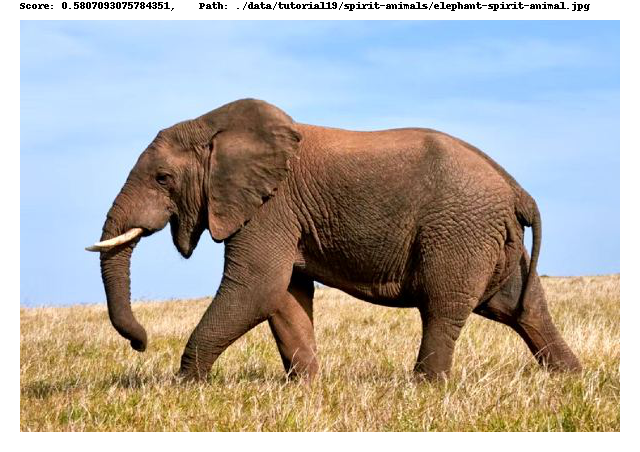

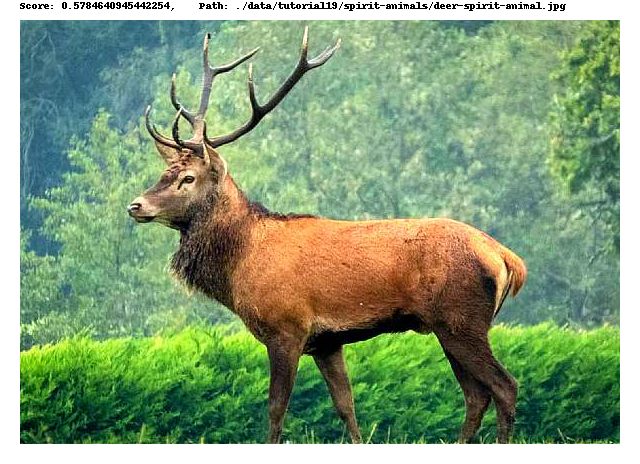

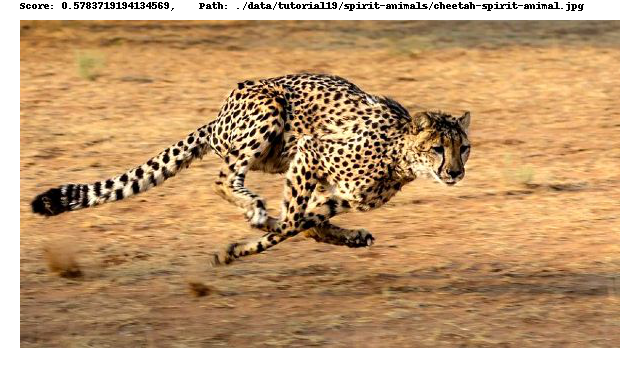

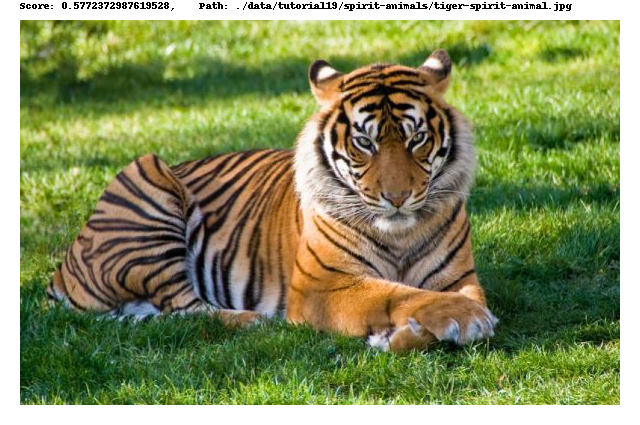

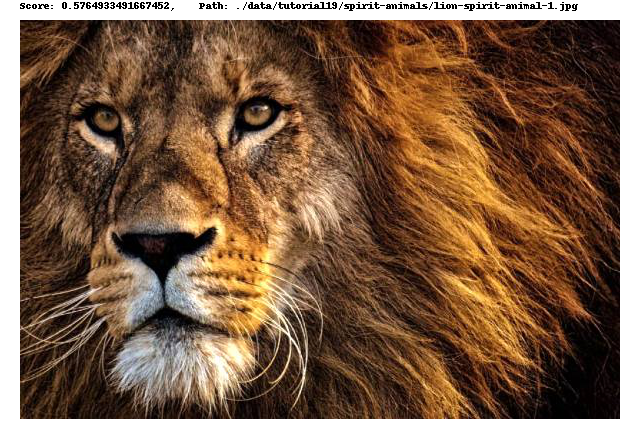

In [12]:
from io import BytesIO
from PIL import Image, ImageDraw, ImageOps
from IPython.display import display, Image as IPImage


def display_img_array(ima, score):
    im = Image.open(ima)
    img_with_border = ImageOps.expand(im, border=20, fill="white")

    # Add Text to an image
    img = ImageDraw.Draw(img_with_border)
    img.text((20, 0), f"Score: {score},    Path: {ima}", fill=(0, 0, 0))

    bio = BytesIO()
    img_with_border.save(bio, format="png")
    display(IPImage(bio.getvalue(), format="png"))


images_array = [doc.content for doc in results]
scores = [doc.score for doc in results]
for ima, score in zip(images_array, scores):
    display_img_array(ima, score)

Congratulations! You've created a search system that returns images of animals in answer to a text query.

## About us

This [Haystack](https://github.com/deepset-ai/haystack/) notebook was made with love by [deepset](https://deepset.ai/) in Berlin, Germany

We bring NLP to the industry via open source!  
Our focus: Industry specific language models & large scale QA systems.  
  
Some of our other work: 
- [German BERT](https://deepset.ai/german-bert)
- [GermanQuAD and GermanDPR](https://deepset.ai/germanquad)

Get in touch:
[Twitter](https://twitter.com/deepset_ai) | [LinkedIn](https://www.linkedin.com/company/deepset-ai/) | [Discord](https://haystack.deepset.ai/community/join) | [GitHub Discussions](https://github.com/deepset-ai/haystack/discussions) | [Website](https://deepset.ai)

By the way: [we're hiring!](https://www.deepset.ai/jobs)